FEATURE ENGINEERING FOR ELECTRICITY PRICE FORECASTING

✓ Data loaded: 94820 records
Date range: 2015-01-01 00:00:00 to 2025-10-27 07:00:00
Existing columns (13): ['timestamp', 'price_eur_mwh', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'week', 'is_holiday', 'is_weekend', 'is_outlier_iqr', 'is_outlier_zscore']

CREATING LAG FEATURES

Creating lag features for: [1, 2, 3, 6, 12, 24, 48, 168] hours
  ✓ price_lag_1h created
  ✓ price_lag_2h created
  ✓ price_lag_3h created
  ✓ price_lag_6h created
  ✓ price_lag_12h created
  ✓ price_lag_24h created
  ✓ price_lag_48h created
  ✓ price_lag_168h created

Missing values after lagging:
  First 168 rows will have NaN (expected)
  Total NaN in price_lag_168h: 168

CREATING ROLLING STATISTICS

Creating rolling features for windows: [6, 12, 24, 48, 168] hours
  ✓ Rolling features for 6h window created
  ✓ Rolling features for 12h window created
  ✓ Rolling features for 24h window created
  ✓ Rolling features for 48h window created
  ✓

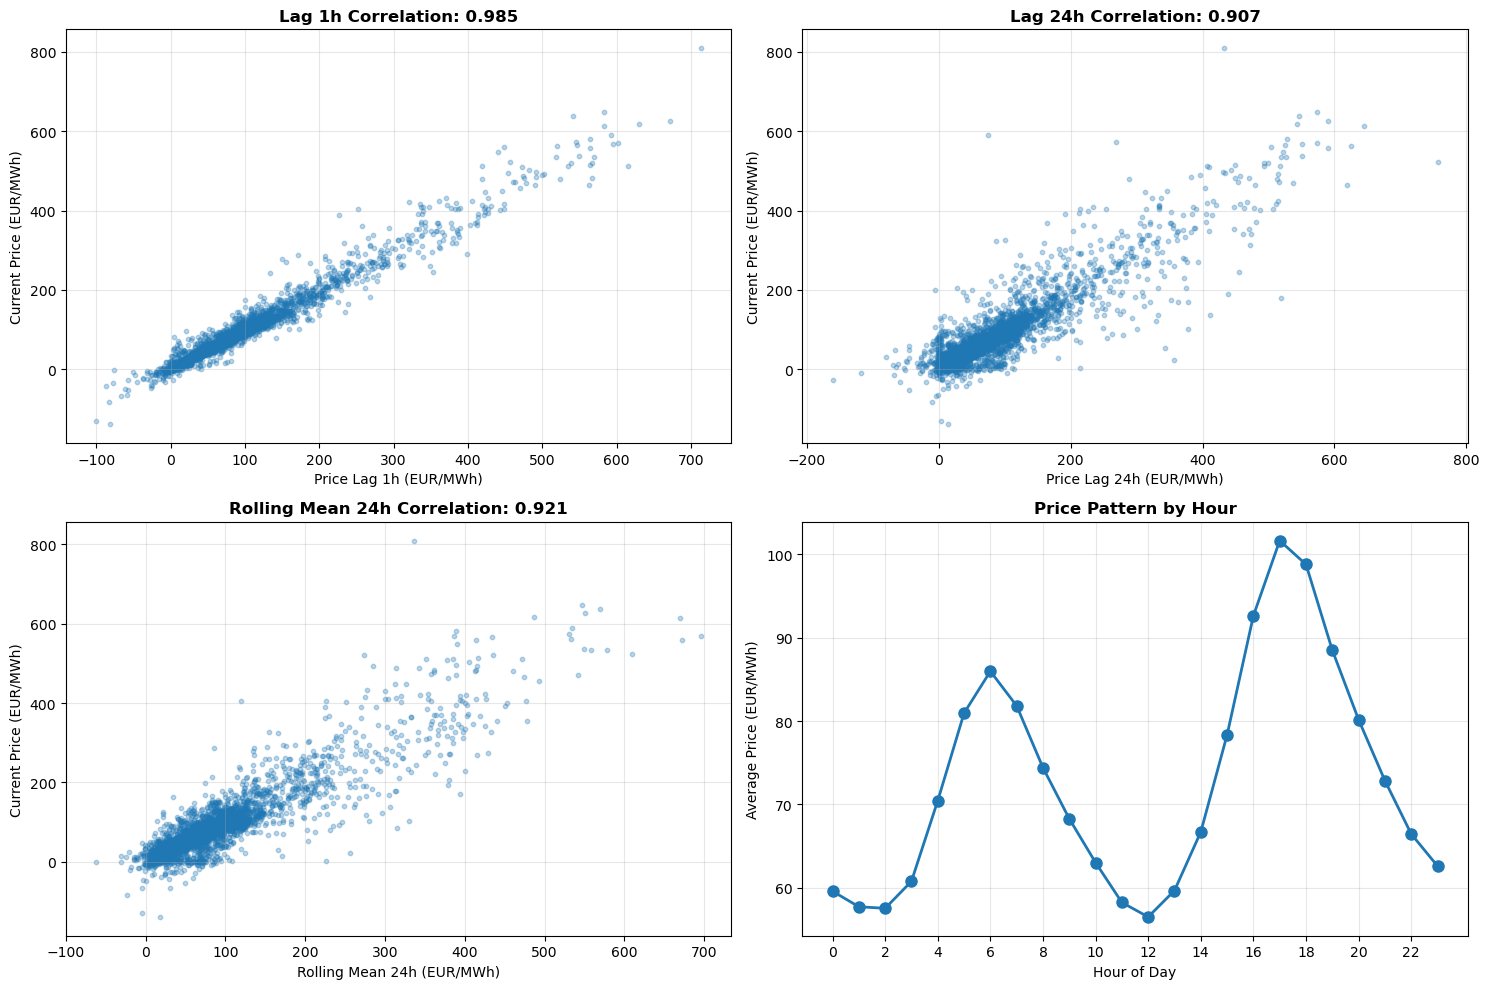

✓ Saved: data/processed/03_correlation_analysis.png


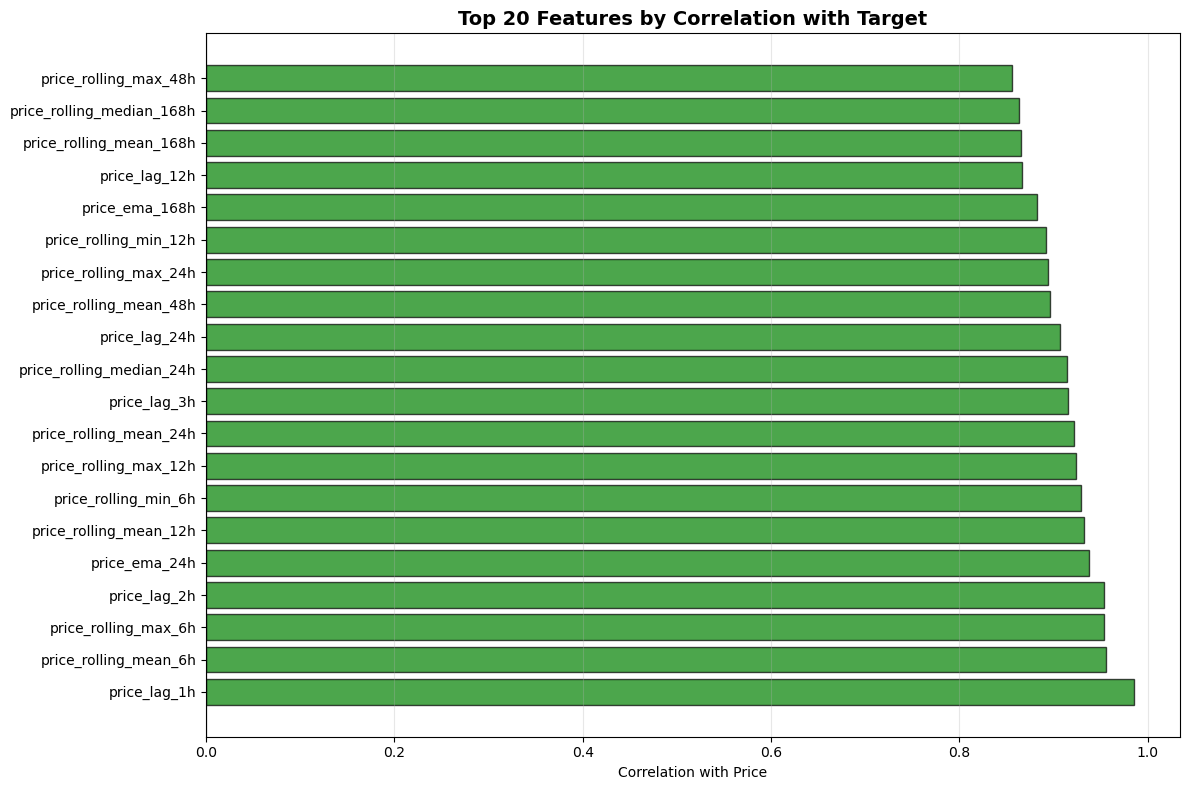


SAVING FEATURE-ENGINEERED DATA
✓ Saved: data/processed/electricity_prices_features.csv
  Shape: (94652, 80)
  Size: 55.06 MB
✓ Saved: data/processed/feature_names.json

FEATURE ENGINEERING COMPLETE

FEATURE ENGINEERING SUMMARY

Dataset Information:
--------------------
  Original records:          94,820
  After cleaning (NaN drop): 94,652
  Total features:            80
  Date range:                2015-01-08 00:00:00 to 2025-10-27 07:00:00

Feature Categories:
-------------------
  Lag features:              8
  Rolling statistics:        22
  Price changes:             10
  Cyclical encodings:        9
  Interaction features:      4
  Volatility features:       4
  Calendar features:         6
  Statistical features:      6

Top 5 Correlated Features:
---------------------------
  1. price_lag_1h.................................  0.9849
  2. price_rolling_mean_6h........................  0.9557
  3. price_rolling_max_6h.........................  0.9535
  4. price_lag_2h............

In [1]:
# 03_Feature_Engineering.ipynb

"""
EV Charging Optimisation - Feature Engineering
===============================================

This notebook creates advanced features for electricity price forecasting:
- Lag features (past prices)
- Rolling statistics (moving averages, volatility)
- Temporal encodings (cyclical features)
- Price change features
- External calendar features

Goal: Build a rich feature set for time series forecasting models

Output: Feature-engineered dataset ready for model training

"""

# %% 1. SETUP AND IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

print("="*70)
print("FEATURE ENGINEERING FOR ELECTRICITY PRICE FORECASTING")
print("="*70)

# Load cleaned data from EDA
df = pd.read_csv('data/processed/electricity_prices_cleaned.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\n✓ Data loaded: {len(df)} records")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Existing columns ({len(df.columns)}): {list(df.columns)}")

# Sort by timestamp (critical for time series)
df = df.sort_values('timestamp').reset_index(drop=True)

# %% 2. LAG FEATURES (PAST PRICE VALUES)

print("\n" + "="*70)
print("CREATING LAG FEATURES")
print("="*70)

# Lags: 1h, 2h, 3h, 6h, 12h, 24h (1 day), 48h (2 days), 168h (1 week)
lag_hours = [1, 2, 3, 6, 12, 24, 48, 168]

print(f"\nCreating lag features for: {lag_hours} hours")

for lag in lag_hours:
    df[f'price_lag_{lag}h'] = df['price_eur_mwh'].shift(lag)
    print(f"  ✓ price_lag_{lag}h created")

# Check missing values from lagging
print(f"\nMissing values after lagging:")
print(f"  First {max(lag_hours)} rows will have NaN (expected)")
print(f"  Total NaN in price_lag_168h: {df['price_lag_168h'].isna().sum()}")

# %% 3. ROLLING STATISTICS

print("\n" + "="*70)
print("CREATING ROLLING STATISTICS")
print("="*70)

# Windows: 6h, 12h, 24h, 48h, 168h (1 week)
windows = [6, 12, 24, 48, 168]

print(f"\nCreating rolling features for windows: {windows} hours")

for window in windows:
    # Rolling mean
    df[f'price_rolling_mean_{window}h'] = df['price_eur_mwh'].rolling(
        window=window, min_periods=1
    ).mean()
    
    # Rolling std (volatility)
    df[f'price_rolling_std_{window}h'] = df['price_eur_mwh'].rolling(
        window=window, min_periods=1
    ).std()
    
    # Rolling min
    df[f'price_rolling_min_{window}h'] = df['price_eur_mwh'].rolling(
        window=window, min_periods=1
    ).min()
    
    # Rolling max
    df[f'price_rolling_max_{window}h'] = df['price_eur_mwh'].rolling(
        window=window, min_periods=1
    ).max()
    
    print(f"  ✓ Rolling features for {window}h window created")

# Rolling median (24h and 168h only - computationally expensive)
for window in [24, 168]:
    df[f'price_rolling_median_{window}h'] = df['price_eur_mwh'].rolling(
        window=window, min_periods=1
    ).median()
    print(f"  ✓ price_rolling_median_{window}h created")

print(f"\n✓ Total rolling features created: {len([c for c in df.columns if 'rolling' in c])}")

# %% 4. PRICE CHANGE FEATURES

print("\n" + "="*70)
print("CREATING PRICE CHANGE FEATURES")
print("="*70)

# Price differences (hour-over-hour changes)
change_periods = [1, 6, 12, 24, 168]

for period in change_periods:
    # Absolute change
    df[f'price_diff_{period}h'] = df['price_eur_mwh'].diff(period)
    
    # Percentage change
    df[f'price_pct_change_{period}h'] = df['price_eur_mwh'].pct_change(period) * 100
    
    print(f"  ✓ Price change features for {period}h created")

print(f"\n✓ Total price change features: {len([c for c in df.columns if 'diff' in c or 'pct_change' in c])}")

# %% 5. CYCLICAL TEMPORAL FEATURES (SINE/COSINE ENCODING)

print("\n" + "="*70)
print("CREATING CYCLICAL TEMPORAL FEATURES")
print("="*70)

# Hour of day (0-23) -> Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
print("  ✓ hour_sin, hour_cos created")

# Day of week (0-6) -> Cyclical encoding
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
print("  ✓ dayofweek_sin, dayofweek_cos created")

# Day of year (1-365) -> Cyclical encoding
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
print("  ✓ dayofyear_sin, dayofyear_cos created")

# Month (1-12) -> Cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
print("  ✓ month_sin, month_cos created")

print("\n💡 Why cyclical encoding?")
print("   - Hour 23 and Hour 0 are adjacent (not 23 units apart)")
print("   - Preserves temporal continuity for ML models")
print("   - Better than one-hot encoding for continuous cycles")

# %% 6. INTERACTION FEATURES

print("\n" + "="*70)
print("CREATING INTERACTION FEATURES")
print("="*70)

# Hour × Weekend interaction
df['hour_x_weekend'] = df['hour'] * df['is_weekend']
print("  ✓ hour_x_weekend created")

# Hour × Month interaction (capture seasonal hourly patterns)
df['hour_x_month'] = df['hour'] * df['month']
print("  ✓ hour_x_month created")

# Price ratio: current vs 24h lag
df['price_ratio_24h'] = df['price_eur_mwh'] / (df['price_lag_24h'] + 1e-6)
print("  ✓ price_ratio_24h created")

# Price ratio: current vs 168h lag
df['price_ratio_168h'] = df['price_eur_mwh'] / (df['price_lag_168h'] + 1e-6)
print("  ✓ price_ratio_168h created")

print(f"\n✓ Total interaction features: 4")

# %% 7. VOLATILITY FEATURES

print("\n" + "="*70)
print("CREATING VOLATILITY FEATURES")
print("="*70)

# Coefficient of variation (rolling)
for window in [24, 168]:
    df[f'price_cv_{window}h'] = (
        df[f'price_rolling_std_{window}h'] / 
        (df[f'price_rolling_mean_{window}h'] + 1e-6)
    )
    print(f"  ✓ price_cv_{window}h (coefficient of variation) created")

# Price range (max - min) over rolling windows
for window in [24, 168]:
    df[f'price_range_{window}h'] = (
        df[f'price_rolling_max_{window}h'] - 
        df[f'price_rolling_min_{window}h']
    )
    print(f"  ✓ price_range_{window}h created")

print(f"\n✓ Total volatility features: 4")

# %% 8. CALENDAR FEATURES (ADVANCED)

print("\n" + "="*70)
print("CREATING ADVANCED CALENDAR FEATURES")
print("="*70)

# Business hour flag (8-18h on weekdays)
df['is_business_hour'] = (
    (df['hour'] >= 8) & (df['hour'] < 18) & (df['is_weekend'] == 0)
).astype(int)
print("  ✓ is_business_hour created")

# Night hour flag (22-6h)
df['is_night'] = (
    (df['hour'] >= 22) | (df['hour'] < 6)
).astype(int)
print("  ✓ is_night created")

# Peak hour flag (based on EDA: typically 18-20h)
df['is_peak_hour'] = (
    (df['hour'] >= 18) & (df['hour'] <= 20)
).astype(int)
print("  ✓ is_peak_hour created")

# Off-peak hour flag (typically 2-5h)
df['is_offpeak_hour'] = (
    (df['hour'] >= 2) & (df['hour'] <= 5)
).astype(int)
print("  ✓ is_offpeak_hour created")

# Quarter of year
df['quarter'] = df['month'].apply(lambda x: (x - 1) // 3 + 1)
print("  ✓ quarter created")

# Season (meteorological: 1=Winter, 2=Spring, 3=Summer, 4=Fall)
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5]:
        return 2  # Spring
    elif month in [6, 7, 8]:
        return 3  # Summer
    else:
        return 4  # Fall

df['season'] = df['month'].apply(get_season)
print("  ✓ season created")

print(f"\n✓ Total calendar features: 6")

# %% 9. STATISTICAL FEATURES

print("\n" + "="*70)
print("CREATING STATISTICAL FEATURES")
print("="*70)

# Z-score (standardized price relative to 168h rolling window)
df['price_zscore_168h'] = (
    (df['price_eur_mwh'] - df['price_rolling_mean_168h']) / 
    (df['price_rolling_std_168h'] + 1e-6)
)
print("  ✓ price_zscore_168h created")

# Distance from rolling mean
df['price_deviation_24h'] = df['price_eur_mwh'] - df['price_rolling_mean_24h']
df['price_deviation_168h'] = df['price_eur_mwh'] - df['price_rolling_mean_168h']
print("  ✓ price_deviation features created")

# Exponential moving average (EMA)
df['price_ema_24h'] = df['price_eur_mwh'].ewm(span=24, adjust=False).mean()
df['price_ema_168h'] = df['price_eur_mwh'].ewm(span=168, adjust=False).mean()
print("  ✓ price_ema features created")

print(f"\n✓ Total statistical features: 5")

# %% 10. FEATURE SUMMARY

print("\n" + "="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

feature_groups = {
    'Original': ['timestamp', 'price_eur_mwh', 'year', 'month', 'day', 'hour', 
                 'dayofweek', 'dayofyear', 'week', 'is_holiday', 'is_weekend'],
    'Lag Features': [c for c in df.columns if 'lag' in c],
    'Rolling Statistics': [c for c in df.columns if 'rolling' in c],
    'Price Changes': [c for c in df.columns if 'diff' in c or 'pct_change' in c],
    'Cyclical Encoding': [c for c in df.columns if 'sin' in c or 'cos' in c],
    'Interaction Features': [c for c in df.columns if '_x_' in c or 'ratio' in c],
    'Volatility Features': [c for c in df.columns if 'cv_' in c or 'range_' in c],
    'Calendar Features': ['is_business_hour', 'is_night', 'is_peak_hour', 
                          'is_offpeak_hour', 'quarter', 'season'],
    'Statistical Features': [c for c in df.columns if 'zscore' in c or 'deviation' in c or 'ema' in c],
    'Outlier Flags': [c for c in df.columns if 'outlier' in c]
}

print("\nFeature Groups:")
total_features = 0
for group, features in feature_groups.items():
    count = len(features)
    total_features += count
    print(f"  {group:.<30} {count:>3} features")

print(f"\n{'TOTAL FEATURES':.<30} {total_features:>3}")
print(f"Original columns:              {len(df.columns) - total_features}")
print(f"New columns added:             {total_features - 11}")

# %% 11. HANDLE MISSING VALUES

print("\n" + "="*70)
print("HANDLING MISSING VALUES")
print("="*70)

print("\nMissing values per column:")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print(f"\nColumns with missing values: {len(missing_summary)}")
    print(missing_summary.head(10))
    
    print(f"\n💡 Strategy:")
    print(f"   - Lag features: First N rows have NaN (expected)")
    print(f"   - Rolling features: First few rows have NaN (expected)")
    print(f"   - We'll drop rows with any NaN for model training")
    
    # Drop rows with NaN
    initial_rows = len(df)
    df_clean = df.dropna().reset_index(drop=True)
    dropped_rows = initial_rows - len(df_clean)
    
    print(f"\n✓ Dropped {dropped_rows} rows with NaN ({(dropped_rows/initial_rows*100):.2f}%)")
    print(f"✓ Clean dataset: {len(df_clean)} rows")
else:
    print("✓ No missing values found")
    df_clean = df.copy()

# %% 12. FEATURE CORRELATION ANALYSIS

print("\n" + "="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Select numeric features only
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('price_eur_mwh')  # Remove target

# Calculate correlation with target
correlations = df_clean[numeric_features + ['price_eur_mwh']].corr()['price_eur_mwh'].drop('price_eur_mwh')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("\nTop 20 features correlated with price:")
for i, (feature, corr) in enumerate(correlations_sorted.head(20).items(), 1):
    print(f"  {i:2d}. {feature:.<40} {correlations[feature]:>7.4f}")

# Check for highly correlated features (multicollinearity)
print("\n" + "-"*70)
print("Checking for multicollinearity (|correlation| > 0.95):")

corr_matrix = df_clean[numeric_features].corr()
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\n⚠ Found {len(high_corr_pairs)} highly correlated pairs:")
    for feat1, feat2, corr in high_corr_pairs[:10]:
        print(f"  {feat1} ↔ {feat2}: {corr:.4f}")
    print("\n💡 Consider feature selection or regularization")
else:
    print("✓ No severe multicollinearity detected")

# %% 13. VISUALIZATION - FEATURE IMPORTANCE (PREVIEW)

print("\n" + "="*70)
print("GENERATING FEATURE VISUALIZATIONS")
print("="*70)

# Figure 1: Lag features vs target
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Lag 1h
ax = axes[0, 0]
sample = df_clean.sample(min(5000, len(df_clean)))
ax.scatter(sample['price_lag_1h'], sample['price_eur_mwh'], alpha=0.3, s=10)
ax.set_xlabel('Price Lag 1h (EUR/MWh)')
ax.set_ylabel('Current Price (EUR/MWh)')
ax.set_title(f'Lag 1h Correlation: {correlations["price_lag_1h"]:.3f}', fontweight='bold')
ax.grid(alpha=0.3)

# Lag 24h
ax = axes[0, 1]
ax.scatter(sample['price_lag_24h'], sample['price_eur_mwh'], alpha=0.3, s=10)
ax.set_xlabel('Price Lag 24h (EUR/MWh)')
ax.set_ylabel('Current Price (EUR/MWh)')
ax.set_title(f'Lag 24h Correlation: {correlations["price_lag_24h"]:.3f}', fontweight='bold')
ax.grid(alpha=0.3)

# Rolling mean 24h
ax = axes[1, 0]
ax.scatter(sample['price_rolling_mean_24h'], sample['price_eur_mwh'], alpha=0.3, s=10)
ax.set_xlabel('Rolling Mean 24h (EUR/MWh)')
ax.set_ylabel('Current Price (EUR/MWh)')
ax.set_title(f'Rolling Mean 24h Correlation: {correlations["price_rolling_mean_24h"]:.3f}', fontweight='bold')
ax.grid(alpha=0.3)

# Hour (cyclical)
ax = axes[1, 1]
hourly_mean = df_clean.groupby('hour')['price_eur_mwh'].mean()
ax.plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Price (EUR/MWh)')
ax.set_title('Price Pattern by Hour', fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/03_feature_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data/processed/03_feature_analysis.png")
plt.show()

# Figure 2: Top feature correlations
fig, ax = plt.subplots(figsize=(12, 8))

top_features = correlations_sorted.head(20)
colors = ['green' if x > 0 else 'red' for x in correlations[top_features.index]]
ax.barh(range(len(top_features)), correlations[top_features.index], color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index)
ax.set_xlabel('Correlation with Price')
ax.set_title('Top 20 Features by Correlation with Target', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/03_correlation_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data/processed/03_correlation_analysis.png")
plt.show()

# %% 14. SAVE FEATURE-ENGINEERED DATA

print("\n" + "="*70)
print("SAVING FEATURE-ENGINEERED DATA")
print("="*70)

# Save full dataset
output_path = 'data/processed/electricity_prices_features.csv'
df_clean.to_csv(output_path, index=False)
print(f"✓ Saved: {output_path}")
print(f"  Shape: {df_clean.shape}")
print(f"  Size: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save feature names for reference
feature_names = {
    'all_features': df_clean.columns.tolist(),
    'target': 'price_eur_mwh',
    'timestamp_col': 'timestamp',
    'numeric_features': numeric_features,
    'categorical_features': ['is_holiday', 'is_weekend', 'is_business_hour', 
                             'is_night', 'is_peak_hour', 'is_offpeak_hour'],
}

import json
with open('data/processed/feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)
print("✓ Saved: data/processed/feature_names.json")

# %% 15. FINAL SUMMARY

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)

summary = f"""
FEATURE ENGINEERING SUMMARY
============================

Dataset Information:
--------------------
  Original records:          {len(df):,}
  After cleaning (NaN drop): {len(df_clean):,}
  Total features:            {len(df_clean.columns)}
  Date range:                {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}

Feature Categories:
-------------------
  Lag features:              {len([c for c in df_clean.columns if 'lag' in c])}
  Rolling statistics:        {len([c for c in df_clean.columns if 'rolling' in c])}
  Price changes:             {len([c for c in df_clean.columns if 'diff' in c or 'pct_change' in c])}
  Cyclical encodings:        {len([c for c in df_clean.columns if 'sin' in c or 'cos' in c])}
  Interaction features:      {len([c for c in df_clean.columns if '_x_' in c or 'ratio' in c])}
  Volatility features:       {len([c for c in df_clean.columns if 'cv_' in c or 'range_' in c])}
  Calendar features:         {len(['is_business_hour', 'is_night', 'is_peak_hour', 'is_offpeak_hour', 'quarter', 'season'])}
  Statistical features:      {len([c for c in df_clean.columns if 'zscore' in c or 'deviation' in c or 'ema' in c])}

Top 5 Correlated Features:
---------------------------
"""

for i, (feature, corr) in enumerate(correlations_sorted.head(5).items(), 1):
    summary += f"  {i}. {feature:.<45} {correlations[feature]:>7.4f}\n"

summary += f"""
Data Quality:
-------------
  Missing values:            {df_clean.isnull().sum().sum()}
  Duplicate timestamps:      {df_clean['timestamp'].duplicated().sum()}
  
Ready for Model Training:
-------------------------
  ✓ All features engineered
  ✓ No missing values
  ✓ Temporal continuity preserved
  ✓ Feature correlations analysed
  
NEXT STEPS:
===========
→ Run 04_model_training.ipynb
   - Train/validation/test split (time-based)
   - Model selection: LightGBM, XGBoost, ARIMA/SARIMA
   - Hyperparameter tuning
   - 72-hour forecast evaluation
"""

print(summary)

# Save summary
# with open('data/processed/FEATURE_ENGINEERING_REPORT.txt', 'w') as f:
with open('data/processed/FEATURE_ENGINEERING_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✓ Report saved: data/processed/FEATURE_ENGINEERING_REPORT.txt")
print("✓✓✓ FEATURE ENGINEERING COMPLETE ✓✓✓")
print("\nReady for: 04_model_training.ipynb")
